<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:black;'>
    BlueMath - HyTCWaves
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:black;'>
    Non-stationary SWAN: vortex winds, <u>historical</u> TC (north hemisphere)
</p>

<hr size="5"/>

<span style='font-family: times, Times New Roman; font-size:12pt; color:black;'> 
    This is an example of the HyTCwaves toolbox. <br>
    A single historic storm track is used to compute the associated wind fields along its track coordinates, and solve numerical wave propagation. <br>
    Scenario is a demo case based on Kwajalein atoll (Marshall Islands). <br>
</span>

<hr size="5"/>


<span style='font-family: times, arial; font-size:14pt; font-weight:bold; color:black;'> Table of Contents </span>

* [1. Load data (from preprocessing nb)](#1.-Load-data-(from-preprocessing-nb))


* [2. SWAN project](#2.-SWAN-project)
    * [2.1 SWAN main mesh](#2.1-SWAN-main-mesh)
    * [2.2 SWAN nested mesh](#2.2-SWAN-nested-mesh)
    * [2.3 SWAN case parameters](#2.3-SWAN-case-parameters)
    * [2.4 SWAN input: storm track, no waves](#2.4-SWAN-input:-storm-track,-no-waves)


* [3. Plot site configuration](#3.-Plot-site-configuration)


* [4. SWAN WRAP](#4.-SWAN-WRAP)
    * [4.1 Build cases](#4.1-Build-cases)
        * [Plot input: Vortex winds](#Plot-input:-Vortex-winds)
        * [Plot input: Graffiti maximum winds](#Plot-input:-Graffiti-maximum-winds)
    * [4.2 Run cases](#4.2-Run-cases)
        * [Plot output: Hsig](#Plot-output:-Hsig)
        * [Plot output: Graffiti maximum Hsig](#Plot-output:-Graffiti-maximum-Hsig)
        * [Plot output: Control Point time series](#Plot-output:-Control-Point-time-series)
    * [4.3 Extract output](#4.3-Extract-output)

<br>

<div class="alert alert-block alert-warning">
    
<b>Info:</b> this notebook imports SWAN input data (from preprocessing nb), defines SWAN configuration and meshes, builds and runs SWAN case. </div>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', 'hywaves'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import historic_track_preprocessing, historic_track_interpolation

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_case_input, \
plot_case_output_grafiti, plot_case_vortex_grafiti, plot_case_output_points, \
plot_case_vortex_input, plot_case_output


##  **1. Load data (from preprocessing nb)**

In [2]:
site = 'Kwajalein'

# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', 'data'))
p_input = op.join(p_data, 'sites', site)

# load shoreline
np_shore = np.load(op.join(p_input, 'shore_{0}.npy'.format(site)))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_input, 'depth_{0}.nc'.format(site)))

# load storm
name = 'PAKA'
storm = xr.open_dataset(op.join(p_input, 'storm_ibtracs_{0}_{1}.nc'.format(name, site)))


##  **2. SWAN project**

In [3]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_01a_paka'                  # project name

sp = SwanProject(p_proj, n_proj)

# some optional data (will be used at plotting)
sp.shore = np_shore  # project shoreline


###  **2.1 SWAN main mesh**

In [4]:
# get variables from bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]
depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
res = 0.136  # (15km = 0.136º)  

main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),

}

sp.set_main_mesh(main_mesh)


###  **2.2 SWAN nested mesh**

In [5]:
# lets cut inputh depth to a smaller area
xds_bathy_nest = xds_bathy.sel(
    lon = slice(165, 170),
    lat = slice(7, 10),
)

# get variables from bathymetry 
lon = xds_bathy_nest.lon.values[:]
lat = xds_bathy_nest.lat.values[:]
depth = xds_bathy_nest.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
mesh_nest = SwanMesh()

# depth grid description (input bathymetry grid)
mesh_nest.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
mesh_nest.dg_idla = 3

# depth value (from file)
mesh_nest.depth = depth

# computational grid description
res_nest = 0.04545

mesh_nest.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res_nest),
    'myc': int((lat[-1]-lat[0])/res_nest),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res_nest),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res_nest),

}

# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest])


###  **2.3 SWAN case parameters**

In [6]:

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    'output_deltt': '30 MIN',
    
    'output_points_x': [167.7336],
    'output_points_y': [8.66686],

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ],

    'output_variables': ['HSIGN', 'DIR', 'PDIR', 'TM02', 'TPS', 'DSPR', 'WATLEV', 'WIND', 'OUT'],
    
}
sp.set_params(input_params)


###  **2.4 SWAN input: storm track, no waves**

In [7]:
# target coordinates
target = 'Kwajalein'
x0, y0 = 167.73, 8.72

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]


# preprocess storm variables
d_vns = {
    'longitude':'lon_wmo',
    'latitude':'lat_wmo',
    'time': 'time_wmo',
    'pressure':'pres_wmo',
    'maxwinds':'wind_wmo',
}

st_time, ylat_tc, ylon_tc, ycpres, ywind, ts, categ, vmean = historic_track_preprocessing(storm, d_vns)


# computational time step [min] following Vmean criteria: 
# if vmean < 20km/h  dt_comp=20' 
# if vmean > 20km/h  dt_comp=10' 
if vmean*1.852 < 20:      dt_comp = 20
elif vmean*1.852 >= 20:   dt_comp = 10


# generate interpolated storm track  
st, time_input = historic_track_interpolation(
    st_time, ylon_tc, ylat_tc, ycpres, ywind,
    y0, x0, lat[0], lon[0], lat[-1], lon[-1],  
    ts, dt_comp, wind=ywind,
    great_circle=True
)

# [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
st.attrs['override_dtcomp'] = '{0} MIN'.format(dt_comp)

# generate empty wave event
we = pd.DataFrame(index=time_input, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0


##  **3. Plot site configuration**

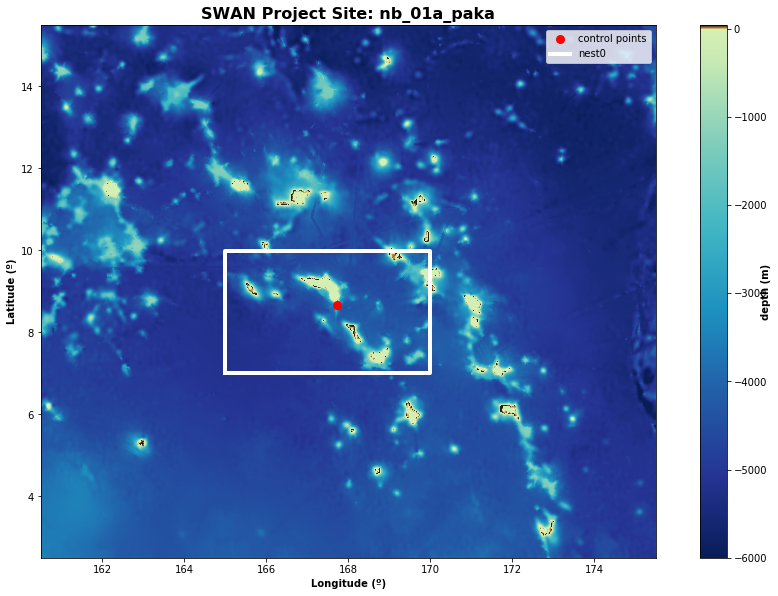

In [8]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp, vmin=-6000, vmax=40);


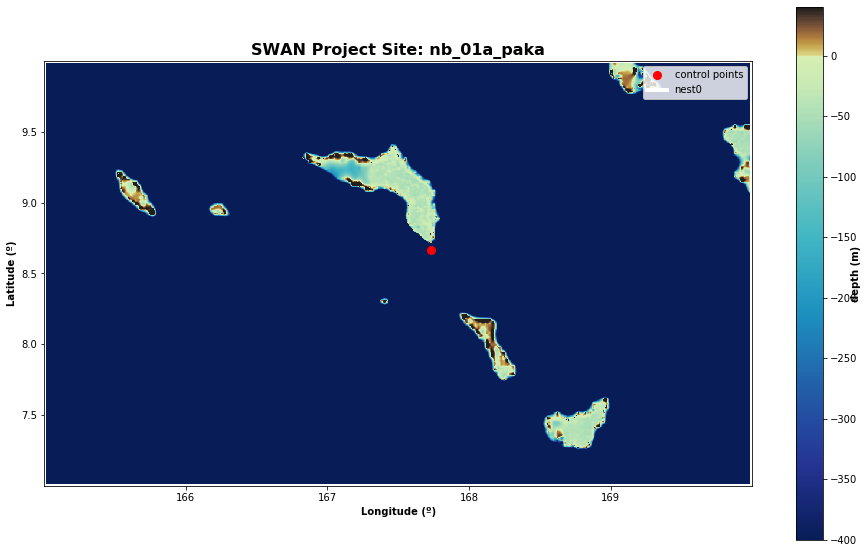

In [9]:
plot_project_site(sp, vmin=-400, vmax=40, zoom=True);


##  **4. SWAN WRAP**

In [8]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


###  **4.1 Build cases**

In [13]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases([we], storm_track_list=[st], make_waves=False, make_levels=False)

CASE 0000 - compute_deltc, wind_deltinp override with storm track: 20 MIN


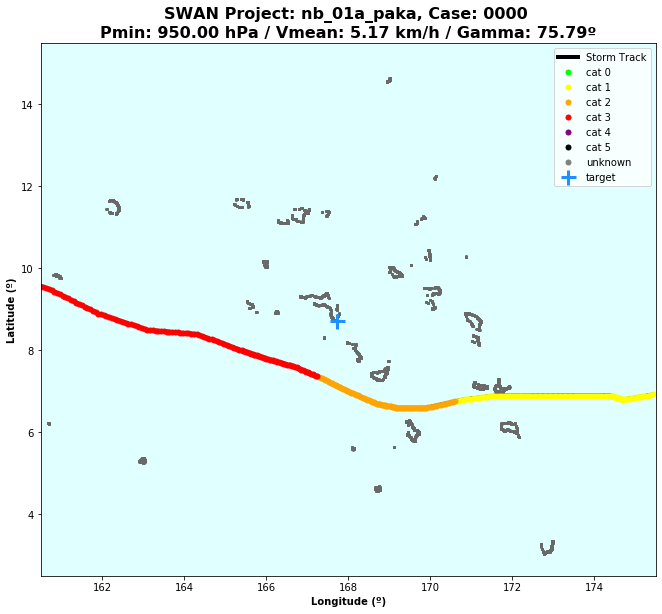

In [11]:
plot_case_input(sp, storm_track_list = [st]);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot input: Vortex winds

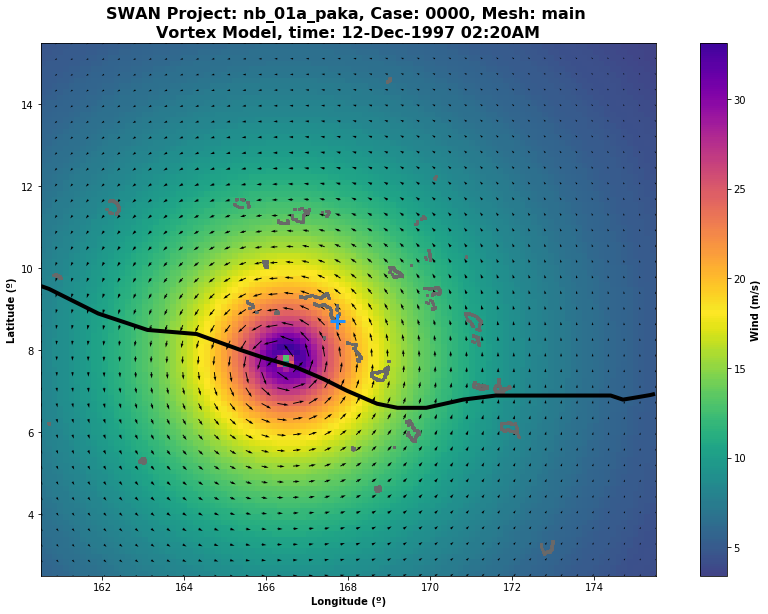

In [20]:
plot_case_vortex_input(sw, storm_track_list = [st], t_num=225);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot input: Graffiti maximum winds

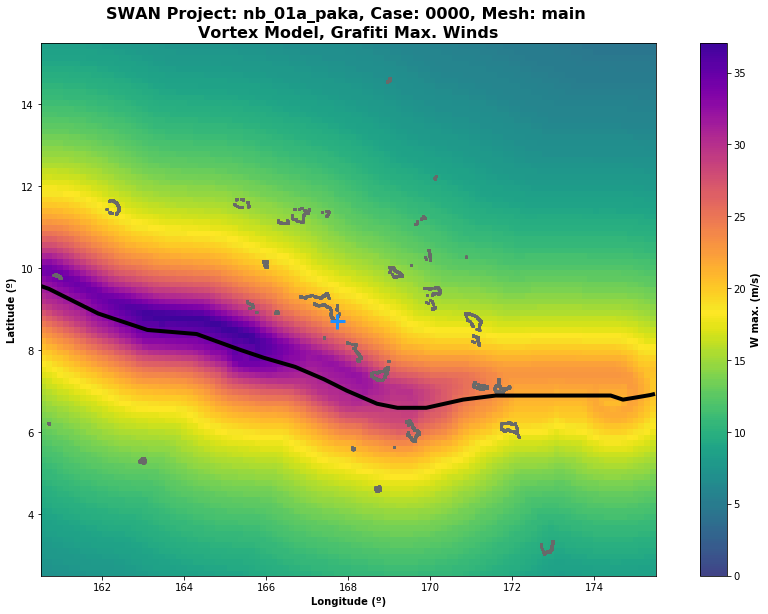

In [14]:
plot_case_vortex_grafiti(sw, storm_track_list = [st]);

###  **4.2 Run cases**

In [17]:
sw.run_cases()

SWAN CASE: 0000 SOLVED


#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Hsig

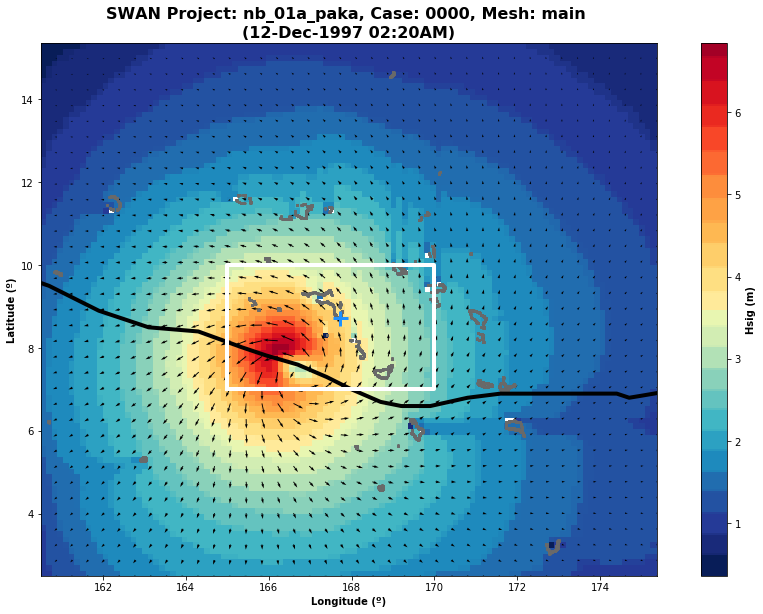

In [22]:
plot_case_output(sw, storm_track_list = [st], t_num=150, show_nested=True);

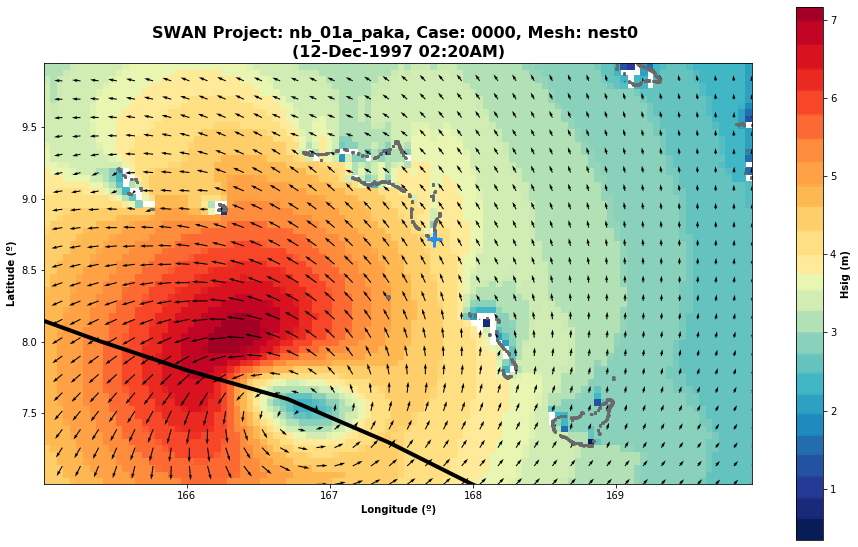

In [21]:
plot_case_output(sw, storm_track_list = [st], mesh=sp.mesh_nested_list[0], t_num=150);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Graffiti maximum Hsig

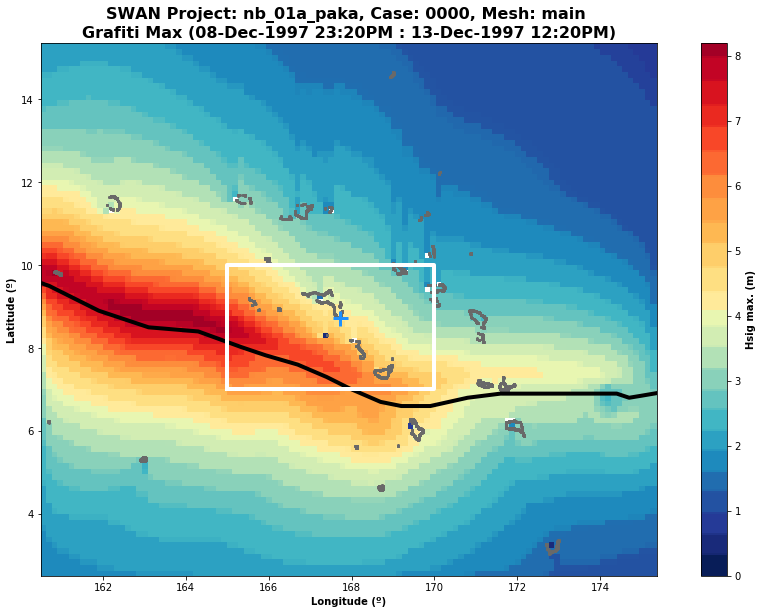

In [21]:
# Plot Hsig max - Main mesh
plot_case_output_grafiti(sw, storm_track_list = [st], show_nested=True);

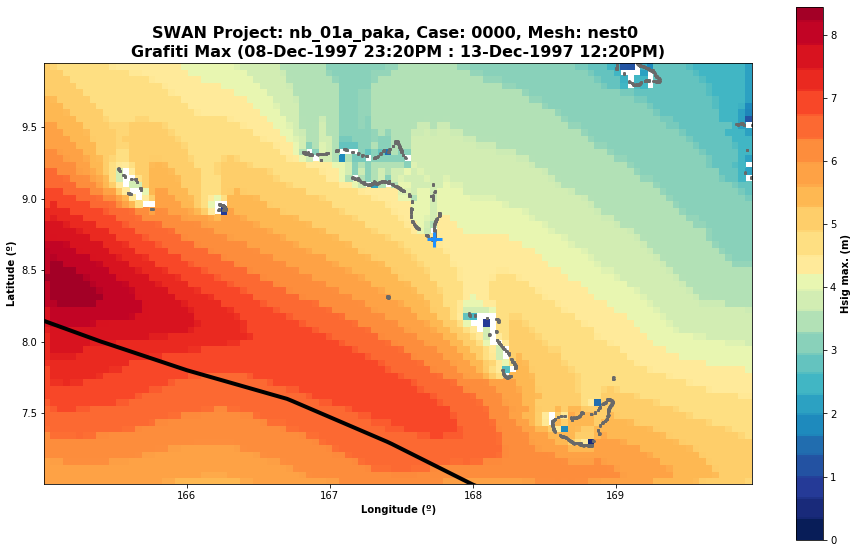

In [22]:
# Plot Hsig max - Nest mesh
plot_case_output_grafiti(sw, storm_track_list = [st], mesh=sp.mesh_nested_list[0]);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Control Point time series

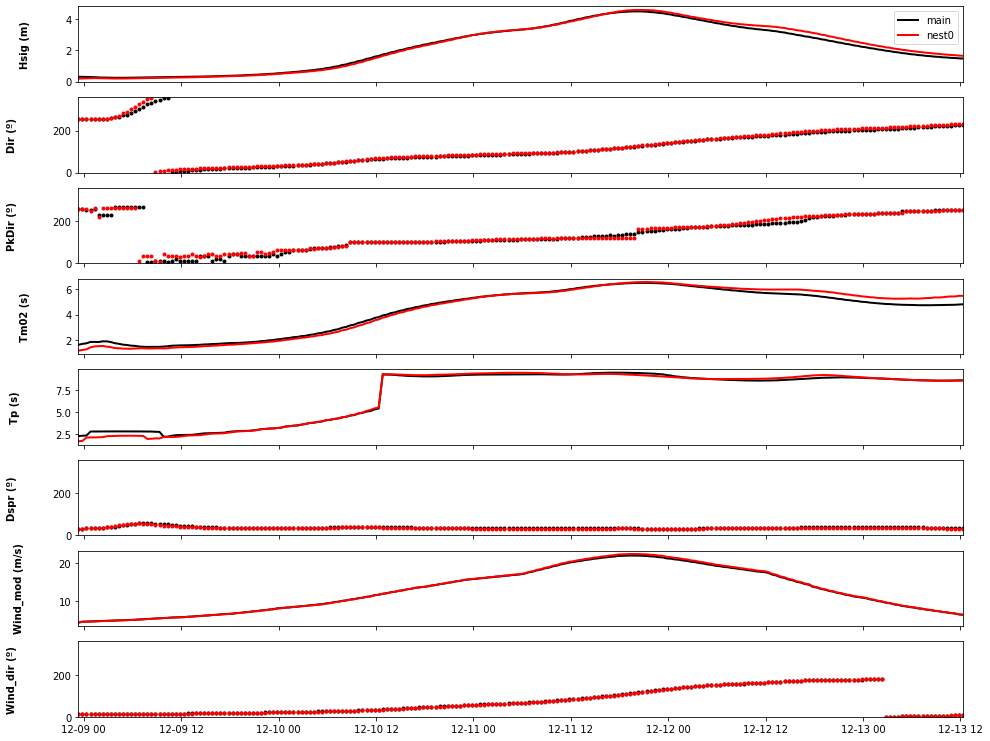

In [9]:
plot_case_output_points(sw);

###  **4.3 Extract output**

####  **Mesh main**

In [24]:
output_main = sw.extract_output()
print(output_main, '\n')

<xarray.Dataset>
Dimensions:     (case: 1, lat: 95, lon: 110, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:20:00
  * lon         (lon) float64 160.5 160.6 160.8 160.9 ... 175.1 175.2 175.4
  * lat         (lat) float64 2.502 2.639 2.776 2.912 ... 15.09 15.22 15.36
Dimensions without coordinates: case
Data variables:
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Dir         (case, time, lat, lon) float32 nan nan ... 211.63892 212.34587
    PkDir       (case, time, lat, lon) float32 nan nan nan ... 212.5 212.5 212.5
    Hsig        (case, time, lat, lon) float32 0.0 0.0 ... 0.9053824 0.9010063
    Tm02        (case, time, lat, lon) float32 nan nan nan ... 7.065583 7.136816
    Tp          (case, time, lat, lon) float32 nan nan nan ... 8.824107 8.828328
    Dspr        (case, time, lat, lon) float32 nan nan ... 10.682446 10.255135
    Windv_x     (case, time, lat, lon) float32 0.38999996 0.40009177

####  **Mesh nested**

In [25]:
output_nest = sw.extract_output(mesh=mesh_nest)
print(output_nest, '\n')

<xarray.Dataset>
Dimensions:     (case: 1, lat: 65, lon: 109, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:20:00
  * lon         (lon) float64 165.0 165.0 165.1 165.1 ... 169.9 169.9 170.0
  * lat         (lat) float64 7.002 7.048 7.094 7.14 ... 9.814 9.86 9.906 9.952
Dimensions without coordinates: case
Data variables:
    WaterLevel  (case, time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Dir         (case, time, lat, lon) float32 269.92892 269.91537 ... 219.63318
    PkDir       (case, time, lat, lon) float32 267.5 267.5 267.5 ... 237.5 237.5
    Hsig        (case, time, lat, lon) float32 0.16562165 ... 1.1758616
    Tm02        (case, time, lat, lon) float32 1.302057 1.3088024 ... 4.7541447
    Tp          (case, time, lat, lon) float32 1.8569996 1.86678 ... 8.874872
    Dspr        (case, time, lat, lon) float32 31.507736 31.508135 ... 31.88015
    Windv_x     (case, time, lat, lon) float32 0.01 0.0 0.0 0.0 ... 0.0 

####  **Points (mesh main)**

In [19]:
output_pts = sw.extract_output_points()
print(output_pts, '\n')

<xarray.Dataset>
Dimensions:     (case: 1, point: 1, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 1997-12-08T23:20:00 ... 1997-12-13T12:20:00
Dimensions without coordinates: case, point
Data variables:
    Hsig        (case, point, time) float64 0.3092 0.304 0.2979 ... 1.487 1.476
    Dir         (case, point, time) float64 256.9 256.0 256.0 ... 227.1 227.7
    PkDir       (case, point, time) float64 257.5 257.5 252.5 ... 252.5 252.5
    Tm02        (case, point, time) float64 1.639 1.712 1.755 ... 4.787 4.805
    Tp          (case, point, time) float64 2.279 2.315 2.336 ... 8.623 8.631
    Dspr        (case, point, time) float64 31.51 33.07 33.46 ... 35.97 35.8
    WaterLevel  (case, point, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Windv_x     (case, point, time) float64 -0.9669 -1.054 ... 0.7694 0.7766
    Windv_y     (case, point, time) float64 -4.16 -4.375 -4.4 ... 6.371 6.269
    x_point     (case, point) float64 167.7
    y_point     (case, point) flo

In [20]:
output_pts.sel(case=0, point=0).Dir.values

array([256.9  , 256.   , 256.   , 255.8  , 255.6  , 255.8  , 256.2  ,
       257.9  , 259.4  , 263.3  , 266.   , 272.7  , 276.7  , 286.5  ,
       292.1  , 305.5  , 313.   , 327.1  , 333.   , 343.7  , 348.2  ,
       355.   , 357.5  ,   1.977,   3.831,   6.892,   8.067,  10.17 ,
        11.22 ,  13.22 ,  14.09 ,  15.73 ,  16.53 ,  17.91 ,  18.53 ,
        19.71 ,  20.22 ,  21.28 ,  21.82 ,  22.81 ,  23.31 ,  24.21 ,
        24.63 ,  25.6  ,  26.   ,  26.95 ,  27.46 ,  28.61 ,  29.16 ,
        30.18 ,  30.69 ,  31.82 ,  32.47 ,  33.91 ,  34.57 ,  36.12 ,
        36.94 ,  38.63 ,  39.49 ,  41.4  ,  42.37 ,  44.51 ,  45.61 ,
        48.03 ,  49.22 ,  51.78 ,  53.05 ,  55.57 ,  56.85 ,  59.27 ,
        60.41 ,  62.44 ,  63.44 ,  65.26 ,  66.06 ,  67.56 ,  68.29 ,
        69.54 ,  70.11 ,  71.13 ,  71.63 ,  72.56 ,  72.97 ,  73.84 ,
        74.24 ,  75.11 ,  75.57 ,  76.44 ,  76.88 ,  77.66 ,  78.1  ,
        78.88 ,  79.27 ,  80.06 ,  80.47 ,  81.27 ,  81.67 ,  82.51 ,
        82.96 ,  83.